# - **lung CT images**
- Design my own U-Net to segment the lung fields from chest computed tomography CT images 
- (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)
- Image Size: $512\times512\times1$

# `01` **Import Libraries**

In [ ]:
import gdown
import numpy as np
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Dropout, BatchNormalization, Dense, Conv2D, MaxPool2D, Flatten ,Activation, MaxPooling2D, Input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling
from keras.callbacks import EarlyStopping
keras.utils.set_random_seed(1234)

# `02` hyperparameters


In [ ]:
SEED = 1234
BATCH_SIZE  = 2
EPOCHS = 50
early_stop=EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True,verbose=1)

## `03` **Downlaod, Load & Preprocess Chest CT Data**

## Download & Extract the Dataset

In [ ]:
gdown.download('https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=a01dab3b-b5d9-4ae9-83fb-abcd41452cd9
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:00<00:00, 174MB/s]


'Lung_Data.zip'

In [ ]:
%%capture
! unzip Lung_Data.zip

## **Load & Preprocess the Dataset**

In [ ]:
folders = ['grey', 'mask']
for folder in folders:
    out_dir = f'Lung_Data_PNG/{folder}'
    os.makedirs(out_dir, exist_ok=True)
    for img in glob(f'Lung_Data/{folder}/*.bmp'):
        Image.open(img).save(os.path.join(out_dir, img.split('/')[-1].rsplit('.', maxsplit=1)[0] + '.png'), 'PNG')

In [ ]:
grey_train, grey_val = image_dataset_from_directory('Lung_Data_PNG/grey',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="both")
mask_train, mask_val = image_dataset_from_directory('Lung_Data_PNG/mask',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="both")

Found 216 files.
Using 184 files for training.
Using 32 files for validation.
Found 216 files.
Using 184 files for training.
Using 32 files for validation.


## **Preview some images**

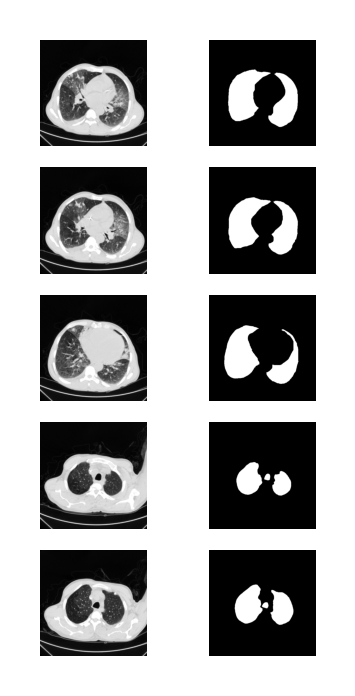

In [ ]:
plt.figure(figsize=(1, 2), dpi=400)
for images, masks in zip(grey_train.take(1), mask_train.take(1)):
    for i in range(4):
        plt.subplot(5, 2, i*2+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.subplot(5, 2, i*2+2)
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')

## `04` **Model Design**

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)
    b1 = Dropout(0.2)(b1)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="U-Net")
    return model

# input image size is (512, 512, 1)
model = build_unet((512, 512, 1))
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_4[0][0]  

 Total params: 7,771,297 (29.65 MB)

 Trainable params: 7,765,409 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

## **Model Compilation & Training**

In [ ]:
model.compile(optimizer="adam",loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train = tf.data.Dataset.zip(grey_train, mask_train.map(lambda x: Rescaling(1./255)(x)))
val = tf.data.Dataset.zip(grey_val, mask_val.map(lambda x: Rescaling(1./255)(x)))

history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=[early_stop],
    steps_per_epoch=grey_train.cardinality().numpy(),
    validation_steps=grey_val.cardinality().numpy()
    )

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 645ms/step - accuracy: 0.9905 - loss: 0.0882 - val_accuracy: 0.1168 - val_loss: 351.1505
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 629ms/step - accuracy: 0.9895 - loss: 0.0741 - val_accuracy: 0.1372 - val_loss: 53.1951
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 643ms/step - accuracy: 0.9923 - loss: 0.0570 - val_accuracy: 0.6269 - val_loss: 6.9951
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 623ms/step - accuracy: 0.9946 - loss: 0.0450 - val_accuracy: 0.8435 - val_loss: 0.6482
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 621ms/step - accuracy: 0.9935 - loss: 0.0426 - val_accuracy: 0.9838 - val_loss: 0.0849
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 629ms/step - accuracy: 0.9933 - loss: 0.0383 - val_accuracy: 0.9905 - val_loss: 0.1008
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 638ms/step - accuracy: 0.9950 - loss: 0.0302 - val_accuracy: 0.9918 - val_loss: 0.0459
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.9954 - loss: 0.0267 - val_a

##  **Model Evaluation**

In [ ]:
val_loss, val_accuracy = model.evaluate(val)
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Loss: {val_loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.9914 - loss: 0.0471
Validation Accuracy: 0.9917713403701782
Validation Loss: 0.04591881483793259


## **Result Visualization**

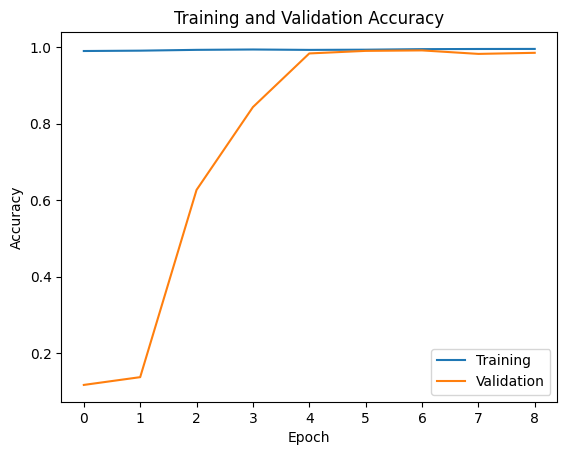

In [ ]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

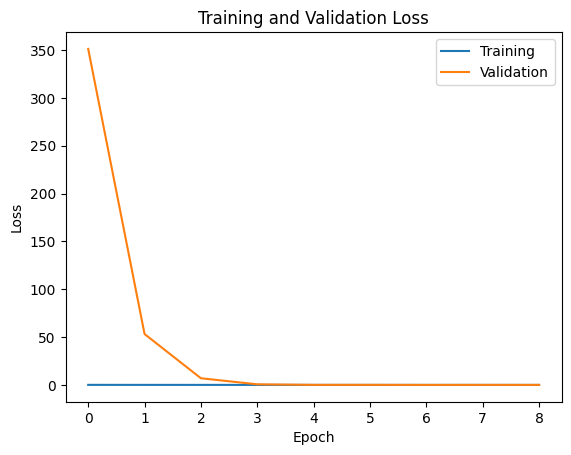

In [ ]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## `06` **Time for Segmentation**

Let's try to predict the mask of some validation samples and plot the results.

In [ ]:
# Function to plot images with masks and predicted masks
def plot_images_with_masks(images, true_masks, pred_masks, thresholds):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, len(thresholds) + 2, figsize=(15, 5*num_images))
    for i in range(num_images):
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(true_masks[i], cmap='gray')
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')
        # Loop through thresholds and plot predicted masks
        for j, thresh in enumerate(thresholds):
            pred_mask = pred_masks[i] > thresh
            axes[i, j+2].imshow(pred_mask, cmap='gray')
            axes[i, j+2].set_title(f'Thresh={thresh}')
    plt.tight_layout()
    plt.show()


num_of_samples = 5
visualize_images = []
visualize_true_masks = []

for _ in range(num_of_samples):
    # Use grey_val and mask_val instead of val_grey and val_mask
    batch_images = next(iter(grey_val)) 
    batch_true_masks = next(iter(mask_val)) 
    
    visualize_images.append(batch_images[0])
    visualize_true_masks.append(batch_true_masks[0])

visualize_images = np.array(visualize_images)
visualize_true_masks = np.array(visualize_true_masks)

pred_masks = model.predict(visualize_images)
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


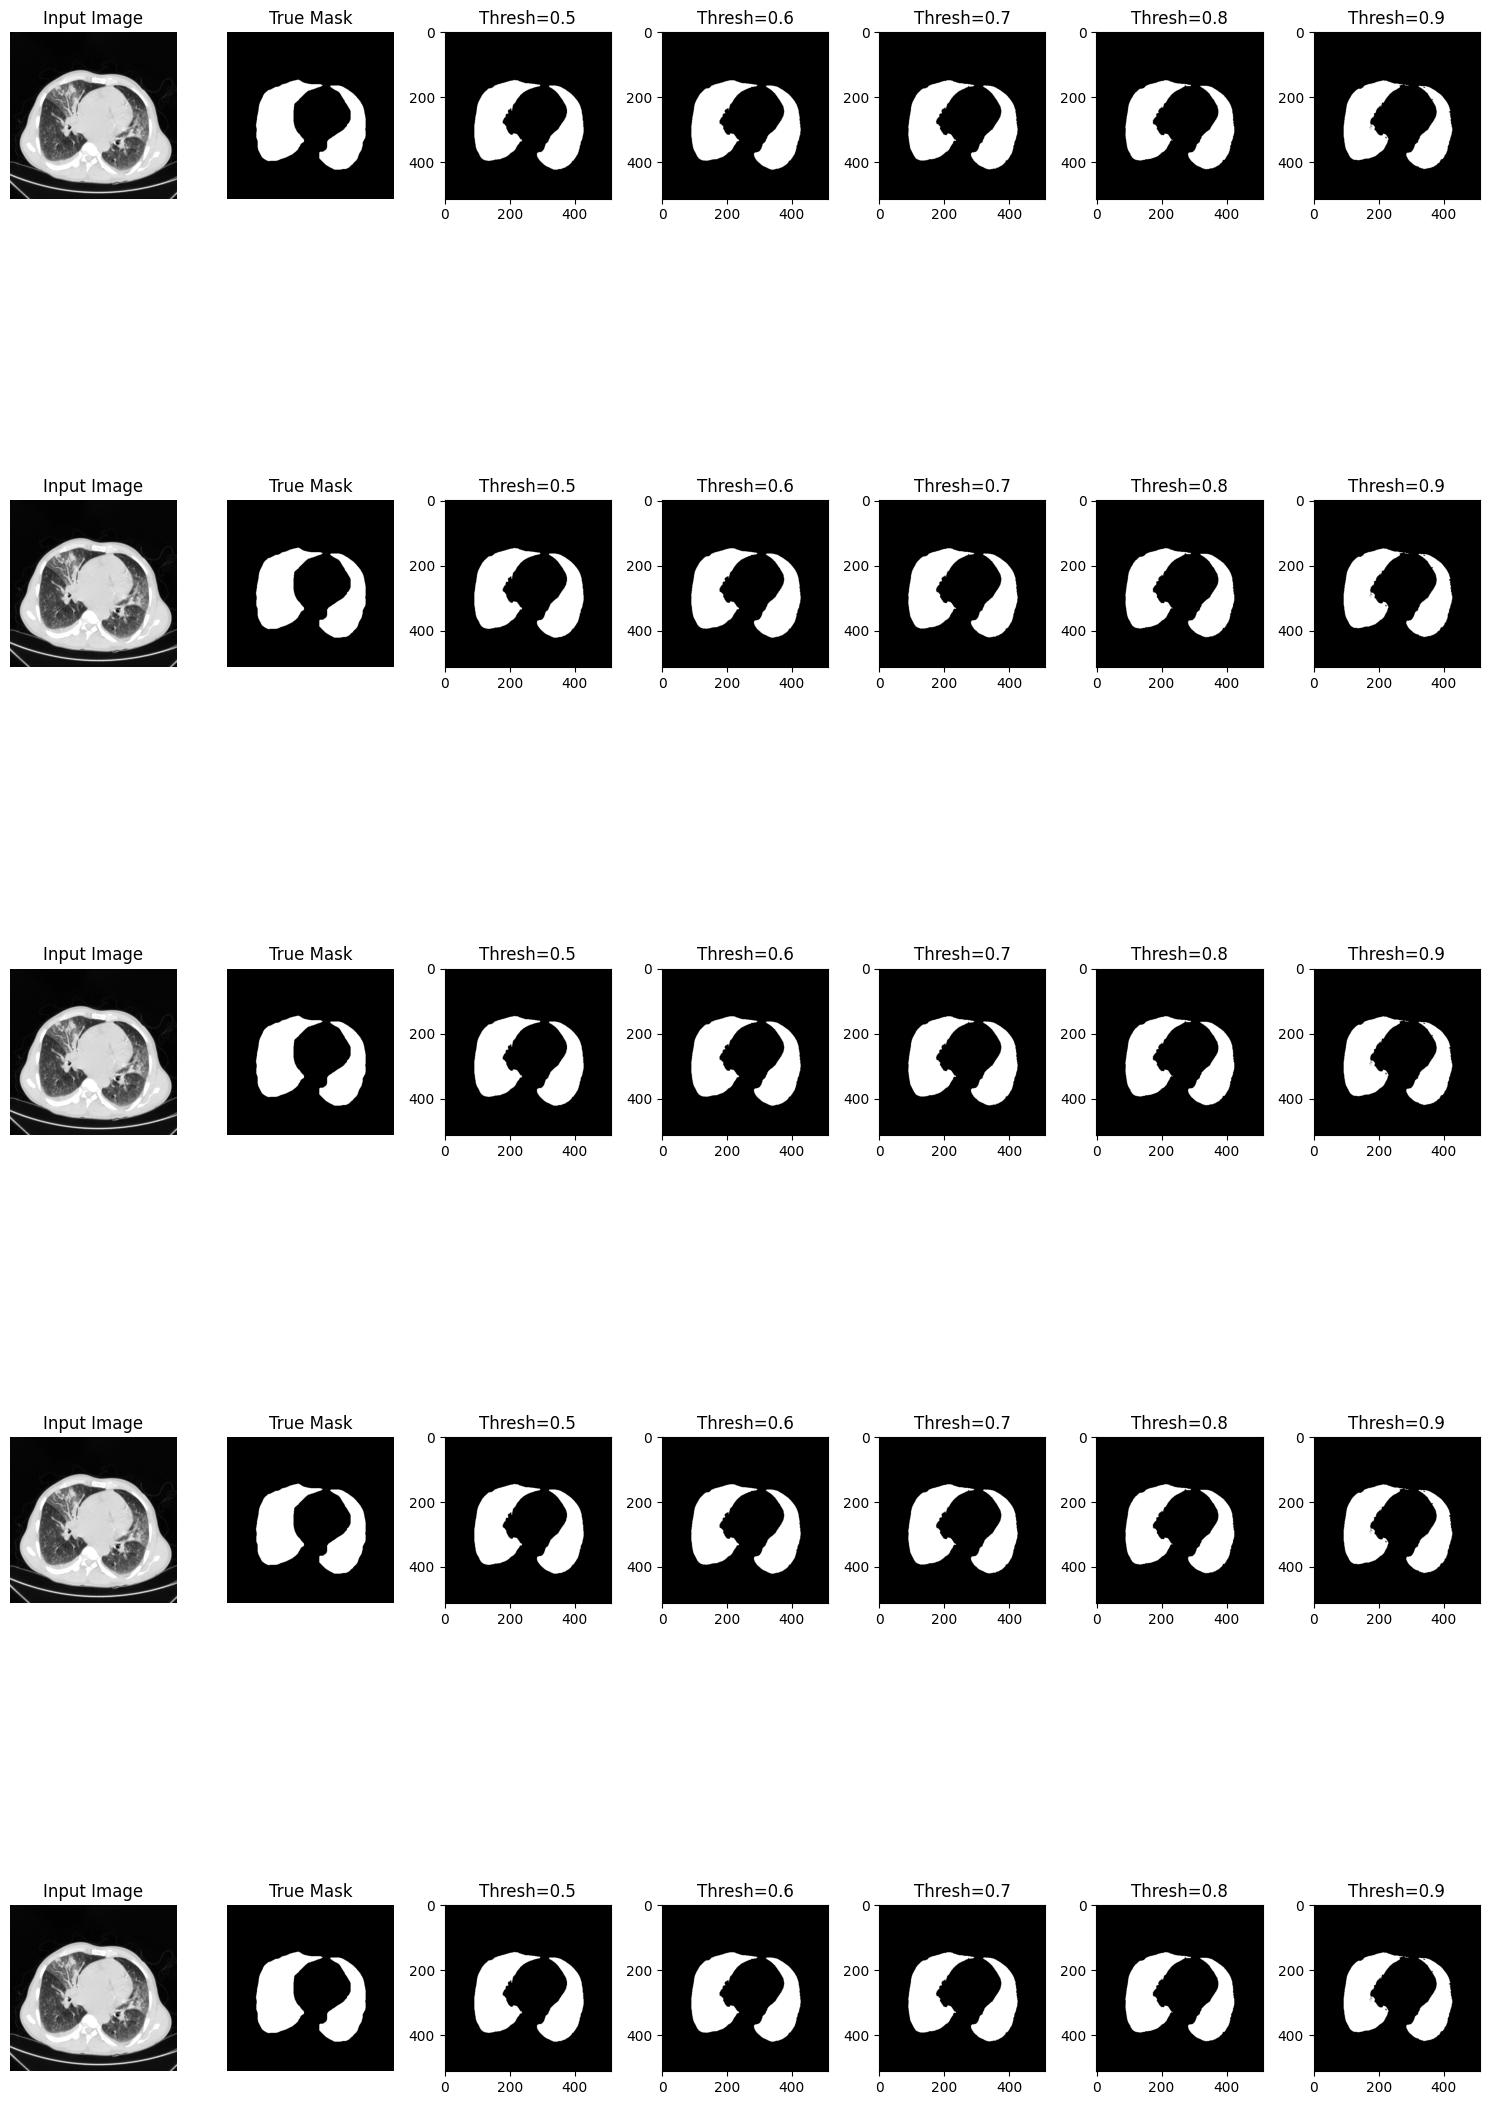

In [ ]:
plot_images_with_masks(visualize_images, visualize_true_masks, pred_masks, thresholds)